# BME 590 - Workshop 1 - Deck Setup
**Professor:** Emma Chory, Ph.D.

**Authors:**
Rick Wierenga, Joe Laforet, Stefan Golas, Ben Perry

---

### Usage Note
**Reminder** - You should be running this notebook **remotely** on **Google Colab** not navigating it through **GitHub**.

---

In the last workshop, we reviewed how to setup a deck and use the visualizer to produce a gif. Now we are going to cover **everything related to deck setup**. For these exercises, since the deck setup is static, and we don't care to watch the initial plates being placed on the deck, we will only ask for a **screenshot** of the final setup.

Furthermore, it is **good practice** to create a **python function** which sets up your initial deck. This will be helpful when testing out your protocol so you can **quickly reset your deck and the visualizer**.

#### Colab Specific Install

Similar to **workshop 0** we are gonig to have to re-install the specialized version of PLR

In [ ]:
%%capture
!git clone https://github.com/benjamin-perry-duke/pylabrobot.git && cd pylabrobot && pip install -e ".[dev]"

Remember to run **Runtime -> Restart Session**

In [ ]:
import pylabrobot.pylabrobot as pylabrobot
import opentrons
import asyncio # colab specific
# colab specific state tracker
active_instances = {
    "lh": None,
    "vis": None
}

#### Setting Up Your (semi-) First Deck & Visualizer

Let's go ahead and set up your first deck for a liquid handler. To set up a liquid handler, you will need three things:

- **Liquid Handler Interface** - This is the top level class that will organize everything else for us.

- **A Deck Layout** - Different machines have different deck sizes/slots. The deck layout tells the LiquidHandler the geometric constraints of our robot.

- **A Backend** -- The backend does the heavy lifting of converting the instructions we write in Python to **machine code** tailored to each robot. Because we do not have a lab component to this class (yet), we must do our experimentation *virtually*. Fortunately, PLR has a built-in `Visualizer` class, which enables us to host a website locally that will display our active experiment as we work!

Let's start with the `LiquidHandler` class. Run the following code.

In [ ]:
from pylabrobot.liquid_handling import LiquidHandler

lh = LiquidHandler() # run this - you will get an error. This is ok!

You should have gotten an **error** that looks like the following:

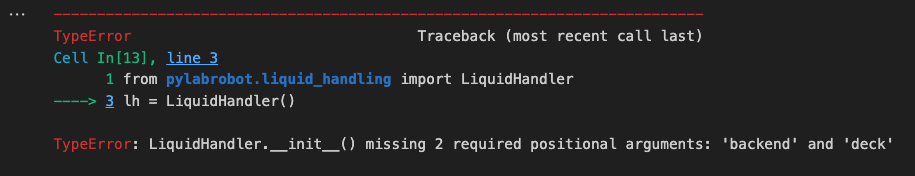

As expected, the `LiquidHandler` won't work without a suitable backend or deck! Let's try using a [Hamilton STAR](https://www.hamiltoncompany.com/microlab-star?srsltid=AfmBOoqFyaWUKXUD4qwBmI0-aVXG-9hHUi02XsAF6NUdgpA8M3uo9SSn) liquid handler. The deck layout should look like this!

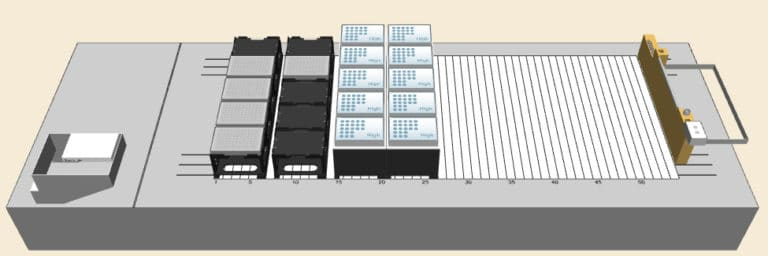

Normally, to use this deck, we would need the `STARBackend` to convert our commands to actual robot movements.

Since we don't have a STAR machine to use for this class, we are going to use the `LiquidHandlerChatterboxBackend` instead, which will print pseudo-actions rather than moving an actual piece of lab machinery. Let's set up the deck now!

In [ ]:
from pylabrobot.liquid_handling import LiquidHandler
from pylabrobot.liquid_handling.backends import LiquidHandlerChatterboxBackend # import backend
from pylabrobot.resources.hamilton import STARLetDeck # import deck layout from pylabrobot.resources.<manufacturer_name>

lh = LiquidHandler(backend = LiquidHandlerChatterboxBackend(),
                   deck = STARLetDeck())

Great! Now we have a deck with a backend. Finally, we need to call `setup()` to assign resources to the liquid handler. PyLabRobot uses a **directed, rooted tree** data structure to organize a liquid handler.

This means every `Resource` will have a `parent` and `children`, except the root. A deck can have children (such as a plate holder or a trash bin), and its children can have children (a plate to a plate holder), and so on (the children of a plate are wells within the plate.)

This is best visualized in the figure below from the PLR paper, where the relationship between a plate well, plate, plate holder, and deck is shown!

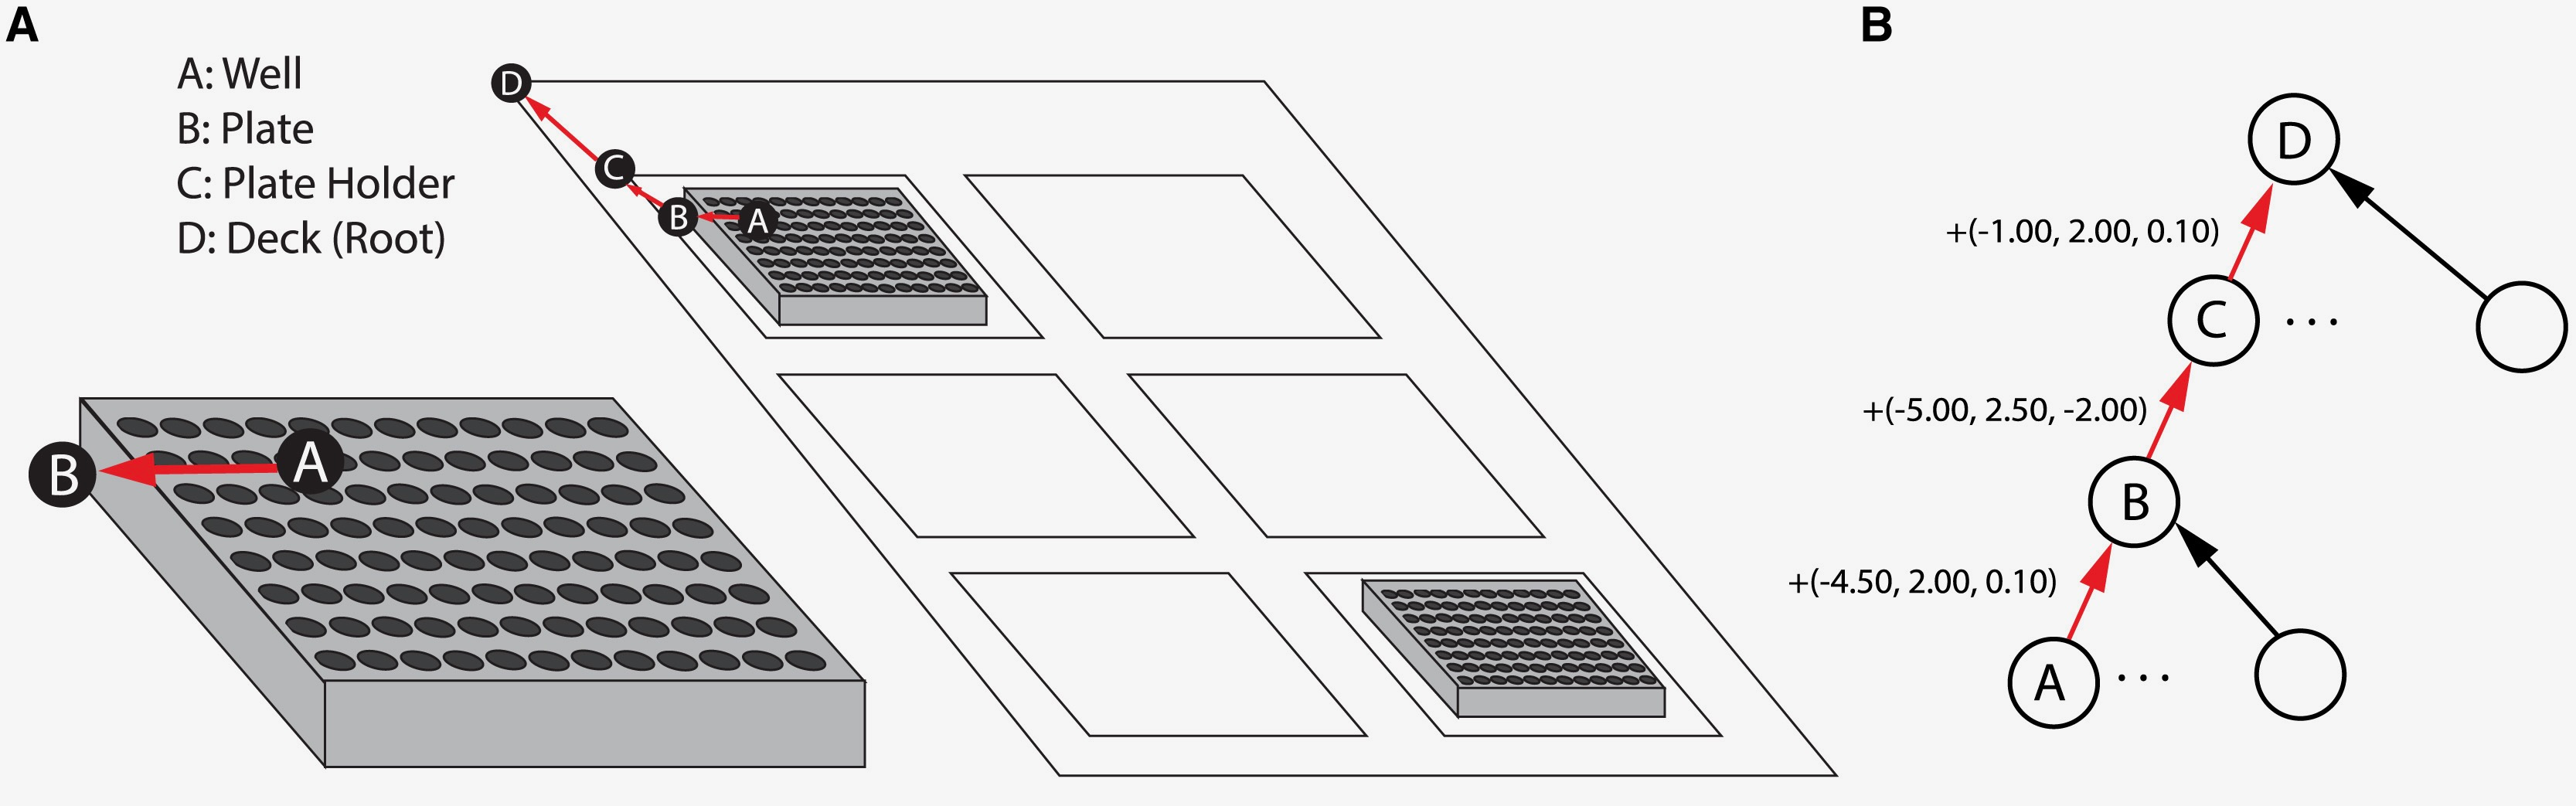

Calling `lh.setup()` will initialilze this data structure with the layout of the STARLet deck and pre-configure it with a trash bin!

In [ ]:
try:
    await lh.setup()
except: # if lh is already running (i.e. this cell is run out of order) then reset via lh.stop()
    await lh.stop()
    await lh.setup()

Great! You should see an output akin to the following.

```txt
Setting up the liquid handler.
Resource deck was assigned to the liquid handler.
Resource trash was assigned to the liquid handler.
Resource trash_core96 was assigned to the liquid handler.
Resource waste_block was assigned to the liquid handler.
```

You can see the default setup for the STARLet deck will assign two trash bins and a waste block. These are children of the deck, which itself is a child of the liquid handler.

We can actually see the children of the deck by iterating through the `children` attribute of the deck.

In [ ]:
for deck_child in lh.deck.children:
    print(f"Name: {deck_child.name}\nLocation: {deck_child.location}\n\n")

The default deck also will assign a `teaching_tip_rack` as a child of the `waste_block`. If you want to look at a specific resource itself, you can access it by calling `get_resource("<resource_name>")`. Let's look at the tip rack itself, which is a child of the waste_block.

In [ ]:
# get_resource will find the waste block if it is a child of lh.deck
waste_block = lh.deck.get_resource("waste_block")
print(waste_block)

# now let's go ahead and get the teaching_tip_rack, which is a child of waste_block
teaching_rack = waste_block.get_resource("teaching_tip_rack")
print(teaching_rack)

# the teaching rack itself has children, which are the individual 8 wells!
for well in teaching_rack.children:
    print(f"Name: {well.name}\nLocation: {well.location}\n\n")

You can also directly access the teaching tip rack by using `get_resource` on the deck. This function will **recursively search all subtrees** to find the resource in question, if it exists.

In [ ]:
# all the following are the same way to get the teaching_tip_rack.
method_1 = lh.get_resource("teaching_tip_rack") # search on root node (liquid handler)
method_2 = lh.deck.get_resource("teaching_tip_rack") # search on deck node (child of liquid handler)
method_3 = lh.deck.get_resource("waste_block").get_resource("teaching_tip_rack") # search on waste_block node (child of deck)

print(method_1 == method_2 == method_3)

You can also print the total summary of the deck with the `lh.deck.summary()` command. Now we can actually see a printed summary of the deck, along with the same tree structure we were iterating over previously!

In [ ]:
print(lh.deck.summary())

#### Assigning Labware

Remember the **tree** structure we were referring to earlier? Adding labware (such as tips, tubes, plates, etc.) is implemented by adding a **child node** to a parent. In most cases, you will simply be adding a **child resource** like a plate to the **deck**.

Unless adding custom labware, almost all the resources you could possibly add are found in the `pylabrobot.resources` submodule. If you are looking for a specific plate type or resouce, simply search for it in this folder of source.

If you are not familiar with `grep`, the next best way to search this is the GitHub search bar online or the search function in VS Code (More on this later. For this assignment, we will list out the relevant resources).

Let's go ahead and import some resources for the HamiltonStar

In [ ]:
# get a tip carrier that holds 5 tip racks of 96 tips (480 total tips) [A00 revision]
from pylabrobot.resources import TIP_CAR_480_A00

# get a plate carrier that can hold 5 deep well 96 Well PCR Plates
from pylabrobot.resources import PLT_CAR_L5AC_A00

# get a corning 360 uL 96 well plate
from pylabrobot.resources import Cor_96_wellplate_360ul_Fb

# get a tip rack with 96 1000ul high volume tip with filter
from pylabrobot.resources import HTF

Great! Now we actually need to build our deck layout. First, let's go ahead and define a function that we can run that will input a deck, a backend, and a liquid handler object and create our visualizer!

In [ ]:
from pylabrobot.resources import Deck
from pylabrobot.liquid_handling.backends.backend import LiquidHandlerBackend
from pylabrobot.visualizer.visualizer import Visualizer

async def visualize_deck_colab(deck: Deck,
                         backend: LiquidHandlerBackend):

    # shut down old instances, if active
    if active_instances["vis"] is not None:
        print("stopping previous visualizer...")
        await active_instances["vis"].stop()
    if active_instances["lh"] is not None:
        print("stopping previous liquid handler...")
        await active_instances["lh"].stop()
        await asyncio.sleep(1)

    # create new lh and vis
    try:
        print("\nsetting up new liquid handler and visualizer...")
        lh = LiquidHandler(backend=backend, deck=deck)
        vis = Visualizer(resource=lh)
        await lh.setup()
        await vis.setup()

        # store states
        active_instances["lh"] = lh
        active_instances["vis"] = vis

        return lh, vis

    except Exception as e:
        print(f"An error occurred: {e}")
        active_instances["lh"] = None
        active_instances["vis"] = None
        return None, None

Now we need to actually create the object that will represent the tip carrier that we can assign to the deck. We need to give each object a unique name as that is the identifier we will use for everything downstream, such as assigning and unassigning resoruces, adding liquid, etc.

We will move these inside a function which sets up an entire deck in one-shot. The reason for this is once a resource is assigned, it gets a `parent` attribute. If cells are run out of order and the deck setup is not functionalized, an error will be thrown.

In general, **set up your deck completely inside a function** to save yourself headaches.

In [ ]:
# create tip carrier object
tip_carrier = TIP_CAR_480_A00(name="awesome tip carrier 96x5")

# create plate carrier object
plate_carrier = PLT_CAR_L5AC_A00(name = "awesome plate carrier")

Now we need to **assign** this resource to the deck. This is akin to adding a child node to the deck node.

To do this, we will call the `assign_child_resource` method on the `STARLetDeck` object to assign the tip and plate carriers to specific locations. For the `STAR` deck layouts, the argument `rails` explains which set of rails to assign the plate carrier to. The way resources are assigned may be **different** for different deck layouts.

For example, the **OpenTrons2** does **not** have rails, but rather **delineated slots**. So if using an OT2, the method call will instead be `assign_child_at_slot` rather than `assign_child_resource`.

In [ ]:
async def make_deck_with_carriers():
    deck = STARLetDeck()
    tip_carrier = TIP_CAR_480_A00(name="awesome tip carrier 96x5")
    plate_carrier = PLT_CAR_L5AC_A00(name = "awesome plate carrier")
    deck.assign_child_resource(plate_carrier, rails = 5)
    deck.assign_child_resource(tip_carrier, rails = 11)
    return deck

deck = await make_deck_with_carriers()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

Great! You should have a layout that looks like this on your visualizer!

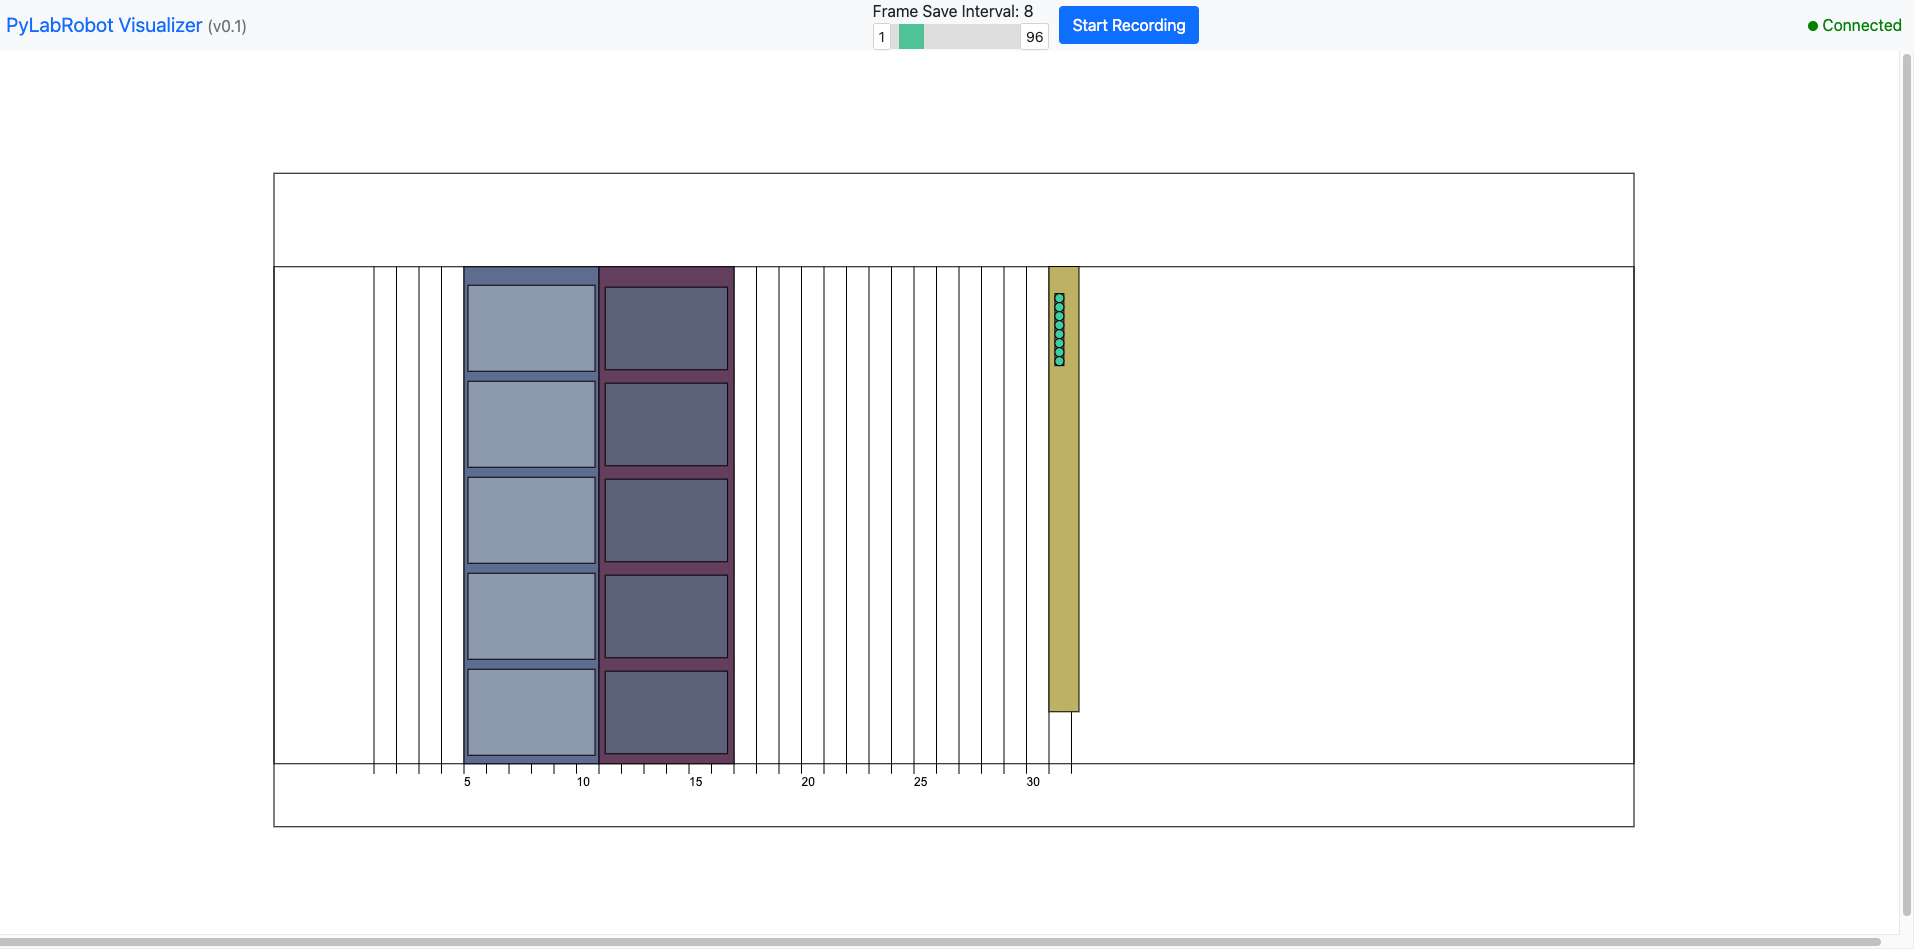

**Note** how the tip carriers are 5 rails wide and are assigned at the correct positions of **rail 5** and **rail 11**. Let's see what happens if we try to run the same code but place the carriers in illegal positions.

In [ ]:
async def make_deck_with_carriers():
    deck = STARLetDeck()
    tip_carrier = TIP_CAR_480_A00(name="awesome tip carrier 96x5")
    plate_carrier = PLT_CAR_L5AC_A00(name = "awesome plate carrier")
    deck.assign_child_resource(plate_carrier, rails = 5)
    deck.assign_child_resource(tip_carrier, rails = 8)
    return deck

deck = await make_deck_with_carriers()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

You should an error noting that the position is already occupied. Therefore, PLR will keep track of the current labware on your particular deck setup!.

```txt
ValueError: Location Coordinate(257.500, 063.000, 100.000) is already occupied by resource 'awesome plate carrier'.
```

You may have also noted we forgot to add tip racks and plates to our deck! Let's go ahead and add **2 tip racks** to our tip rack carrier and **4 plates** to our plate carrier. For **plate carriers**, you can index into their slots using python!

In [ ]:
async def make_deck_with_carriers_and_contents():
    deck = STARLetDeck()

    # create carriers
    tip_carrier = TIP_CAR_480_A00(name="awesome tip carrier 96x5")
    plate_carrier = PLT_CAR_L5AC_A00(name = "awesome plate carrier")

    # assign carriers
    deck.assign_child_resource(plate_carrier, rails = 5)
    deck.assign_child_resource(tip_carrier, rails = 11)

    # define 2 tip racks with unique names and assign to the first two slots of the tip carrier
    for i in range(2):
        tip_carrier[i] = HTF(name=f"tip_rack_{i}")

    # define 4 plates with unique names and assign to the first two slots of the plate carrier
    for i in range(4):
        plate_carrier[i] = Cor_96_wellplate_360ul_Fb(name=f"plate_{i}")

    return deck

deck = await make_deck_with_carriers_and_contents()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

Now we should have something looking like this!

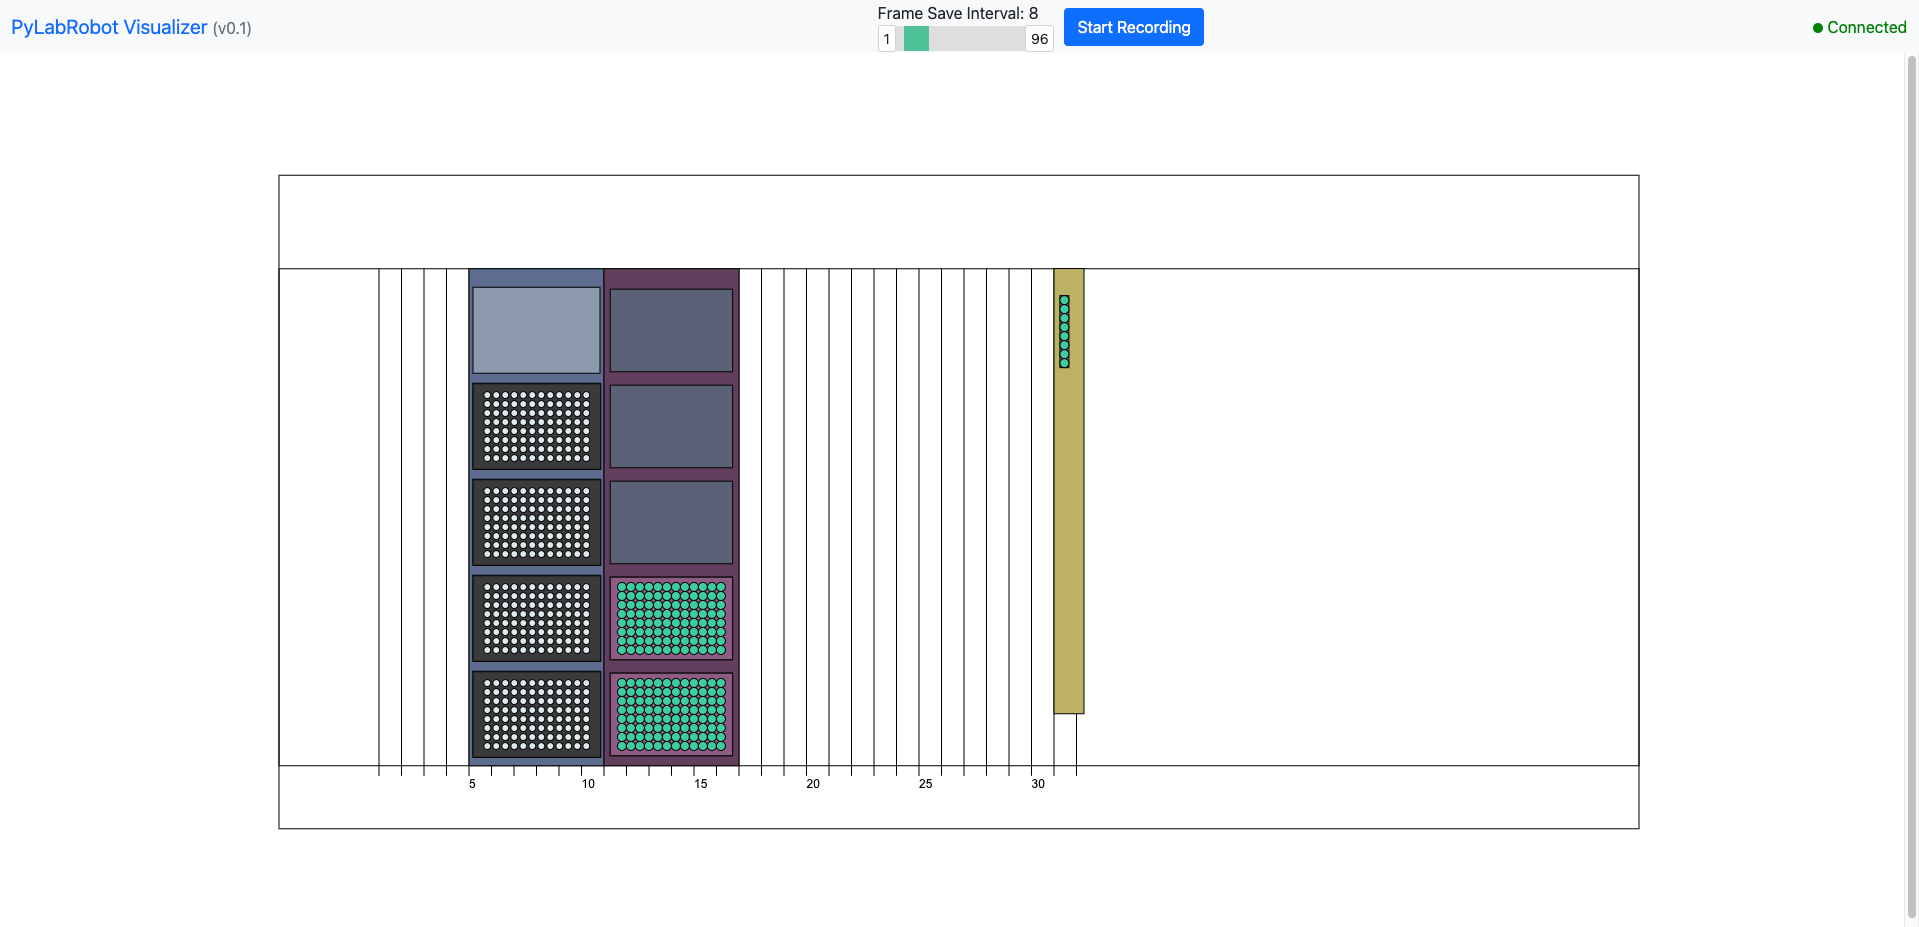

In the visualizer, you can actually hover your mouse over all components on the deck to see their names and how your layout is looking. Pretty neat! Let's see what the deck summary is looking like at this point.

In [ ]:
print(lh.deck.summary())

#### Using Different Decks

When you are working with different decks, there are three primary changes that need to be considered in your code.

1. **Backend** - In practical application, you will need to change your backend to the correct one to match your hardware. For this class, we ignore this as we are using the simulator backend.

2. **Labware** - Labware from different companies will be compatible with different liquid handlers. You need to ensure the equipment you are importing is compatible with the machine you are using. In PLR, labware is organized by manufacturer, and using an incorrect labware will often throw an error if it is physically incompatible.

3. **Methods** - Not only will the layout of your liquid handler change, but sometimes the methods in Python to assign child resources change as well. For example, an **OpenTrons2** liquid handler has **slots** rather than **rails** in which it can assign lab equipment. Not only does the `assign` method change, but also the deck setup, as plate/tip carriers are not needed on an **OpenTrons2**.

In the following section, we will demonstrate setting up a similar deck layout to the STARLet deck, but on an OpenTrons2. Namely, we will need the following equipment on our deck:

- A trash bin

- 2 tip racks with 96 1000 uL tips

- 4 360 uL 96-well plates

Let's start again by importing the equipment we need. You can condense your import code a bit by providing the imports as a tuple.

In [ ]:
from pylabrobot.resources import (
   opentrons_96_tiprack_1000ul, # 96 1000 uL tips
   corning_96_wellplate_360ul_flat # Corning 96-well 360 uL plate
)
from pylabrobot.resources.opentrons import OTDeck # need to import new OpenTrons Deck Layout

async def make_empty_ot2():
    deck = OTDeck()
    return deck

deck = await make_empty_ot2()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

You should see a deck with **11 slots** that looks like this:

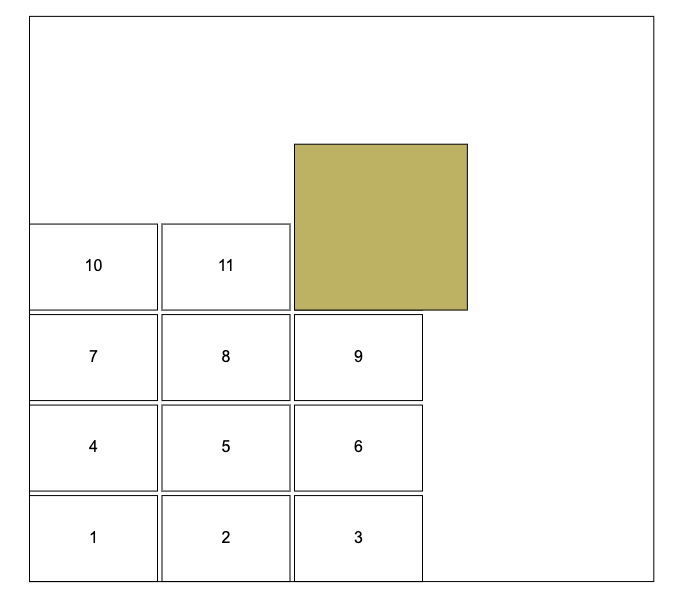

Now, lets's assign **tips** to slots 10 and 11 and **plates** to the bottom-left 4 slots.

In [ ]:
async def make_same_ot2():
    deck = OTDeck()
    tip_rack_slots = [10, 11]
    plate_slots = [1, 2, 4, 5]
    for i, tip_rack_slot in enumerate(tip_rack_slots):
        deck.assign_child_at_slot(opentrons_96_tiprack_1000ul(name = f"tip_rack_{i}"), tip_rack_slot)
    for i, plate_slot in enumerate(plate_slots):
        deck.assign_child_at_slot(corning_96_wellplate_360ul_flat(name = f"plate_{i}"), plate_slot)
    return deck

deck = await make_same_ot2()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

At this point you should have somethign like this

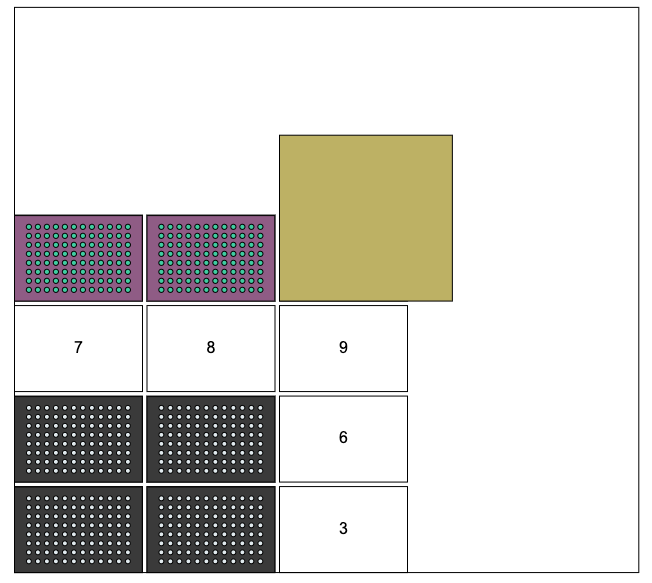

Note the difference in **code** to set up the same deck. You will need to take **special care** to search the resources folder for the equipment you need.

Since we are working with **Colab**, the best way to search resouces is to search for terms on the [PLR Documentation](https://docs.pylabrobot.org/) or the GitHub.

Alternatively, if you are familiar, you can use [grep](https://man7.org/linux/man-pages/man1/grep.1.html).

**Deck Options**

- `STARLetDeck`

- `STARDeck`

- `VantageDeck`

    - `VantageDeck(size=1.3)` - 2.0m variant not supported yet.

- `OTDeck`

- `EVO100Deck`

- `EVO150Deck`

- `EVO200Deck`


Although, we won't grade you for the actual layout of your deck setup (as long as all the requisite pieces of labware are present, here is an important **note** to keep in minde)

---

When designing a protocol, consider both `layout efficiency` and minimizing contamination. Efficient layout reduces pipette travel time, while thoughtful placement minimizes contamination risks.

Place tip racks at the back, stocks in the middle, and plates at the front to allow for `linear movement`. For example, the arm grabs a **tip from slot 7**, aspirates **stock from slot 4**, and dispenses in **slot 1**. Reducing travel time decreases protocol runtime.

Minimizing contamination is akin to sterile technique in manual lab work. In automation, prioritize placement **from clean to contaminated**:

`clean tips -> fresh media -> bacteria -> waste -> bleach`.

Tips should move from **most sterile to least sterile**, and cleaned tips should return to their original position. Avoid allowing contaminated tips to fly over sterile items. For example, in PCR, tips holding primers should not pass over sterile water to prevent downstream contamination.

---

### Exercises

---

**TO-DO:** For each of the following exercises, set up the deck within the `exercise_N()` block of code.

In the Workshop 1 Canvas assignment, submit for each exercise the following:

1. `deck_layout_exercise_N.png` or `deck_layout_exercise_N.jpeg` screenshot of the deck layout for exercises 1 - 4.

2. `exercise_N.txt` text file containing the code that generates the layout for exercises 1 - 4.

---

1. Using an OT2 deck, set up a deck layout that contains:

    - 1 Eppendorf 2mL Safelock Snapcap Acrylic 24-count tube rack

    - 1 Nest 15 mL 15-count conical tube rack

    - 1 12x15 mL reservoir

    - 3 96-well 360 uL plates

In [ ]:
# Exercise 1
async def exercise_1():
    deck = ...
    return deck
deck = await exercise_1()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

2. Using a Hamilton STAR deck, create a plate staircase.

    - A plate staircase shoudl have six plate carriers.

    - There should be a gap of at least 1 rail between each carrier.

    - The leftmost plate staircase should have 0 plates.

    - The rightmorst plate staircase should have 5 plates.

    - Progressively more plates should be added as you move left to right, creating a "staircase" shape.

    - For the STAR deck, start at rail 7.

In [ ]:
# Exercise 2
async def exercise_2():
    deck = ...
    return deck
deck = await exercise_2()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

3. Using an OT2 deck, set up a deck layout that contains:

    - A PCR Plate Adapter in slot 10

    - A PCR Plate Adapter + a PCR plate in slot 11

    - For slots 1-9, design an alternating grid, where:

        - There are the highest possible number of wells possible (given the equipment available in the pylabrobot/resources/opentrons folder) on the X (slots 1,3,5,7,9)
        
        - There are the fewest number of wells possible (given the available equipemnt in pylabrobot/resources/opentrons folder) on the O (slots 2,4,6,8). Hint - a reservoir can have 1 big well sometimes.

In [ ]:
# Exercise 3
async def exercise_3():
    deck = ...
    return deck
deck = await exercise_3()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

4. Using a deck of your choice, **set up a deck layout** for performing a serial dilution of food colorings. Make sure you have enough tips, solution, and the plates/wells are big enough to handle the steps of this protocol.

    - Part A - Code
        - You will start with stock solutions of at least 100 mL each of 1M red, blue, and yellow dye.

        - You will be doing 8 serial dilutions (8 total concentrations) of each color, in triplicate.

        - Your maximum transfer volume at one point (max volume in one tip) will be 500 uL.

        - The maximum volume in a serial dilution well at any point will be 1 mL.
        
        - Don't forget you need diluent/solvent.
    
    - Part B - Comments

        -  Write a 1 sentence justification per equipment choice (including the deck selection) as why it will satisfy the requirements in exercise 4. These sentences should be added as comments in the code below and located by the equipment they are referencing.

        - Add a comment on whether your deck layout is organized from most sterile to least sterile.
        
---

**Note:** Set up the deck only! No need to do any sort of liquid handling yet. We will cover that in future workshops!

---


In [ ]:
# Exercise 4
async def exercise_4():
    deck = ...
    return deck
deck = await exercise_4()
lh, vis = await visualize_deck_colab(deck, LiquidHandlerChatterboxBackend())

---

#### Conclusion

That's all for workshop 1! Double check that you have submitted a `.png/jpeg` file and `.txt` file for each exercise **1-4** and a `.txt` file for **exercise 5**.

If you are still feeling unsure on deck setup, please **reach out to the teaching team**, contact info for whom can be found in the .`README.md` file on the [class GitHub](https://github.com/chory-lab/bme590-fall-2025)

---